In [1]:
import numpy as np
import math
import seaborn as sns
import config as cfg

matplotlib_style = 'default'
import matplotlib.pyplot as plt; plt.style.use(matplotlib_style)
plt.rcParams.update({'axes.labelsize': 'medium',
                     'axes.titlesize': 'medium',
                     'font.size': 14.0})

from SurvivalEVAL.Evaluations.util import KaplanMeier

from data_loader import get_data_loader

sns.set(style="whitegrid")
colors = sns.color_palette("deep")

c:\Users\au475271\Miniconda3\envs\py39-copula\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


metabric; last time: 355.0; last survival probability: 0.0
mimic_hospital; last time: 296.0; last survival probability: 0.20223513027613255
mimic_all; last time: 4404.0; last survival probability: 0.0
seer_brain; last time: 227.0; last survival probability: 0.2657848142797061
seer_liver; last time: 227.0; last survival probability: 0.18010114444117417
seer_stomach; last time: 227.0; last survival probability: 0.28228192419504317


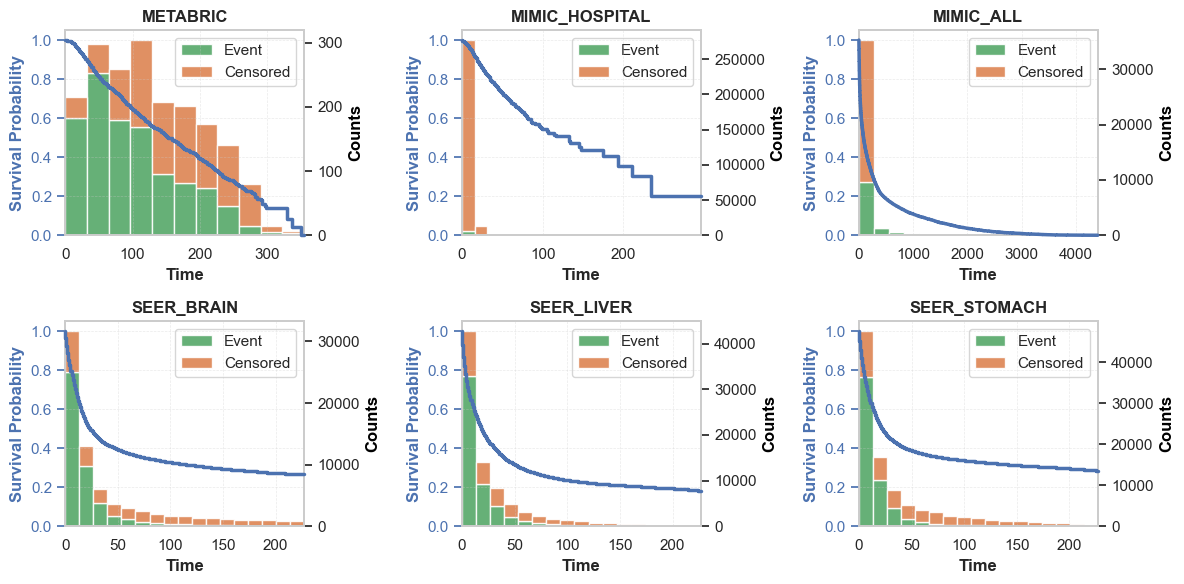

In [4]:
datasets = ["metabric", "mimic_hospital", "mimic_all",
            "seer_brain", "seer_liver", "seer_stomach"]

# Set up a 3x4 grid for the plots
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(12, 6))
axes = axes.flatten()  # Flatten the grid for easier indexing

# Iterate over datasets and axes
for idx, data_name in enumerate(datasets):
    dl = get_data_loader(data_name).load_data()
    data = dl.get_data().reset_index(drop=True)

    event_times = data.time.values[data.event.values == 1]
    censor_times = data.time.values[data.event.values == 0]

    # Sturges formula
    intervals = math.ceil(math.log2(data.shape[0]) + 1)
    bins = np.linspace(0, round(data.time.max()), intervals)

    # Use the specific subplot
    ax0 = axes[idx]

    # Kaplan-Meier Curve
    km_estimator = KaplanMeier(data.time.values, data.event.values)
    survival_times = km_estimator.survival_times
    survival_probabilities = km_estimator.survival_probabilities
    print(f"{data_name}; last time: {survival_times[-1]}; last survival probability: {survival_probabilities[-1]}")
    if survival_times[0] != 0:
        survival_times = np.insert(survival_times, 0, 0)
        survival_probabilities = np.insert(survival_probabilities, 0, 1.0)
    ax0.step(survival_times, survival_probabilities, linewidth=2.5, color=colors[0],
             clip_on=False, zorder=3)
    ax0.set_ylabel("Survival Probability", color=colors[0], weight='bold')
    ax0.set_xlabel("Time", weight='bold')
    ax0.set_ylim([0, 1.05])
    ax0.tick_params(axis='y', colors=colors[0])
    ax0.set_xlim([0, max(survival_times)])
    
    # Adjust grid line properties
    ax0.grid(visible=True, which='major', linestyle='--', linewidth=0.5, alpha=0.4)

    # Histogram
    ax1 = ax0.twinx()
    ax1.hist([event_times, censor_times], bins=bins, histtype='barstacked', stacked=True, alpha=0.9, color=[colors[2], colors[1]], zorder=2)
    ax1.set_ylabel('Counts', color='black', weight='bold')
    ax1.legend(['Event', 'Censored'], loc='best')
    ax1.yaxis.grid(False)
    ax0.set_zorder(ax1.get_zorder() + 1)
    ax0.patch.set_visible(False)

    # Add title to each subplot
    ax0.set_title(data_name.upper(), fontsize=12, weight="bold")

# Remove any unused subplots
for idx in range(len(datasets), len(axes)):
    fig.delaxes(axes[idx])

plt.tight_layout()
plt.savefig(f"{cfg.PLOTS_DIR}/event_distribution.pdf", format='pdf', bbox_inches='tight')
plt.show()